In [77]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [3]:
bucket_name = 'dsde-sireesha-chimbili' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [ ]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'yield_df.csv')).upload_file('yield_df.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://dsde-sireesha-chimbili/yield'.format(bucket_name, prefix), content_type='csv')

In [2]:
import numpy as np 
import pandas as pd 

In [3]:
df_yield = pd.read_csv('s3://dsde-sireesha-chimbili/yield.csv')
df_yield.shape

(56717, 12)

In [4]:
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [5]:
# rename columns.
df_yield = df_yield.rename(index=str, columns={"Value": "hg/ha_yield"})
df_yield.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,hg/ha_yield
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [6]:
# drop unwanted columns.
df_yield = df_yield.drop(['Year Code','Element Code','Element','Year Code','Area Code','Domain Code','Domain','Unit','Item Code'], axis=1)
df_yield.head()

,Area,Item,Year,hg/ha_yield
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260
3,Afghanistan,Maize,1964,14257
4,Afghanistan,Maize,1965,14400


In [7]:
df_yield.describe()

,Year,hg/ha_yield
count,56717.000000,56717.000000
mean,1989.669570,62094.660084
std,16.133198,67835.932856
min,1961.000000,0.000000
25%,1976.000000,15680.000000
50%,1991.000000,36744.000000
75%,2004.000000,86213.000000
max,2016.000000,1000000.000000


In [8]:
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56717 entries, 0 to 56716
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Area         56717 non-null  object
 1   Item         56717 non-null  object
 2   Year         56717 non-null  int64 
 3   hg/ha_yield  56717 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [9]:
df_rain = pd.read_csv('s3://dsde-sireesha-chimbili/rainfall.csv')

df_rain.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [10]:
df_rain = df_rain.rename(index=str, columns={" Area": 'Area'})

In [11]:
# check data types 
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area                           6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.2+ KB


In [12]:
# convert average_rain_fall_mm_per_year from object to float
df_rain['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rain['average_rain_fall_mm_per_year'],errors = 'coerce')
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           6727 non-null   object 
 1   Year                           6727 non-null   int64  
 2   average_rain_fall_mm_per_year  5947 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 210.2+ KB


In [13]:
df_rain = df_rain.dropna()

In [14]:
df_rain.describe()

,Year,average_rain_fall_mm_per_year
count,5947.000000,5947.000000
mean,2001.365899,1124.743232
std,9.526335,786.257365
min,1985.000000,51.000000
25%,1993.000000,534.000000
50%,2001.000000,1010.000000
75%,2010.000000,1651.000000
max,2017.000000,3240.000000


In [15]:
# merge yield dataframe with rain dataframe by year and area columns 
yield_df_updated = pd.merge(df_yield, df_rain, on=['Year','Area'])

In [16]:
yield_df_updated.shape

(25385, 5)

In [17]:
yield_df_updated.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year
0,Afghanistan,Maize,1985,16652,327.0
1,Afghanistan,Potatoes,1985,140909,327.0
2,Afghanistan,"Rice, paddy",1985,22482,327.0
3,Afghanistan,Wheat,1985,12277,327.0
4,Afghanistan,Maize,1986,16875,327.0


In [18]:
yield_df_updated.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year
count,25385.000000,25385.000000,25385.000000
mean,2001.278787,68312.278353,1254.849754
std,9.143915,75213.292733,804.449430
min,1985.000000,50.000000,51.000000
25%,1994.000000,17432.000000,630.000000
50%,2001.000000,38750.000000,1150.000000
75%,2009.000000,94286.000000,1761.000000
max,2016.000000,554855.000000,3240.000000


In [19]:
df_pes = pd.read_csv('s3://dsde-sireesha-chimbili/pesticides.csv')
df_pes.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [20]:
df_pes = df_pes.rename(index=str, columns={"Value": "pesticides_tonnes"})
df_pes = df_pes.drop(['Element','Domain','Unit','Item'], axis=1)
df_pes.head()

,Area,Year,pesticides_tonnes
0,Albania,1990,121.0
1,Albania,1991,121.0
2,Albania,1992,121.0
3,Albania,1993,121.0
4,Albania,1994,201.0


In [21]:
df_pes.describe()

,Year,pesticides_tonnes
count,4349.000000,4.349000e+03
mean,2003.138883,2.030334e+04
std,7.728044,1.177362e+05
min,1990.000000,0.000000e+00
25%,1996.000000,9.300000e+01
50%,2003.000000,1.137560e+03
75%,2010.000000,7.869000e+03
max,2016.000000,1.807000e+06


In [22]:
df_pes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               4349 non-null   object 
 1   Year               4349 non-null   int64  
 2   pesticides_tonnes  4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 135.9+ KB


In [23]:
# merge Pesticides dataframe with yield dataframe 
yield_df_updated = pd.merge(yield_df_updated, df_pes, on=['Year','Area'])
yield_df_updated.shape

(18949, 6)

In [24]:
yield_df_updated.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes
0,Albania,Maize,1990,36613,1485.0,121.0
1,Albania,Potatoes,1990,66667,1485.0,121.0
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0
3,Albania,Sorghum,1990,12500,1485.0,121.0
4,Albania,Soybeans,1990,7000,1485.0,121.0


In [25]:
avg_temp=  pd.read_csv('s3://dsde-sireesha-chimbili/temp.csv')

In [26]:
avg_temp.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [27]:
avg_temp.describe()

,year,avg_temp
count,71311.000000,68764.000000
mean,1905.799007,16.183876
std,67.102099,7.592960
min,1743.000000,-14.350000
25%,1858.000000,9.750000
50%,1910.000000,16.140000
75%,1962.000000,23.762500
max,2013.000000,30.730000


In [28]:
avg_temp = avg_temp.rename(index=str, columns={"year": "Year", "country":'Area'})
avg_temp.head()

,Year,Area,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [29]:
yield_df_updated = pd.merge(yield_df_updated,avg_temp, on=['Area','Year'])
yield_df_updated.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [30]:
yield_df_updated.shape

(28242, 7)

In [31]:
yield_df_updated.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [32]:
yield_df_updated.isnull().sum()

Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [33]:
yield_df_updated.groupby('Item').count()

,Area,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
Item,,,,,,
Cassava,2045,2045,2045,2045,2045,2045
Maize,4121,4121,4121,4121,4121,4121
Plantains and others,556,556,556,556,556,556
Potatoes,4276,4276,4276,4276,4276,4276
"Rice, paddy",3388,3388,3388,3388,3388,3388
Sorghum,3039,3039,3039,3039,3039,3039
Soybeans,3223,3223,3223,3223,3223,3223
Sweet potatoes,2890,2890,2890,2890,2890,2890
Wheat,3857,3857,3857,3857,3857,3857


In [34]:
yield_df_updated.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [35]:
yield_df_updated['Area'].nunique()

101

In [36]:
yield_df_updated.groupby(['Area'],sort=True)['hg/ha_yield'].sum().nlargest(10)

Area
India             327420324
Brazil            167550306
Mexico            130788528
Japan             124470912
Australia         109111062
Pakistan           73897434
Indonesia          69193506
United Kingdom     55419990
Turkey             52263950
Spain              46773540
Name: hg/ha_yield, dtype: int64

In [37]:
yield_df_updated.groupby(['Item','Area'],sort=True)['hg/ha_yield'].sum().nlargest(10)

Item            Area          
Cassava         India             142810624
Potatoes        India              92122514
                Brazil             49602168
                United Kingdom     46705145
                Australia          45670386
Sweet potatoes  India              44439538
Potatoes        Japan              42918726
                Mexico             42053880
Sweet potatoes  Mexico             35808592
                Australia          35550294
Name: hg/ha_yield, dtype: int64

In [38]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_7503/4290299789.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_data, dtype=np.bool)


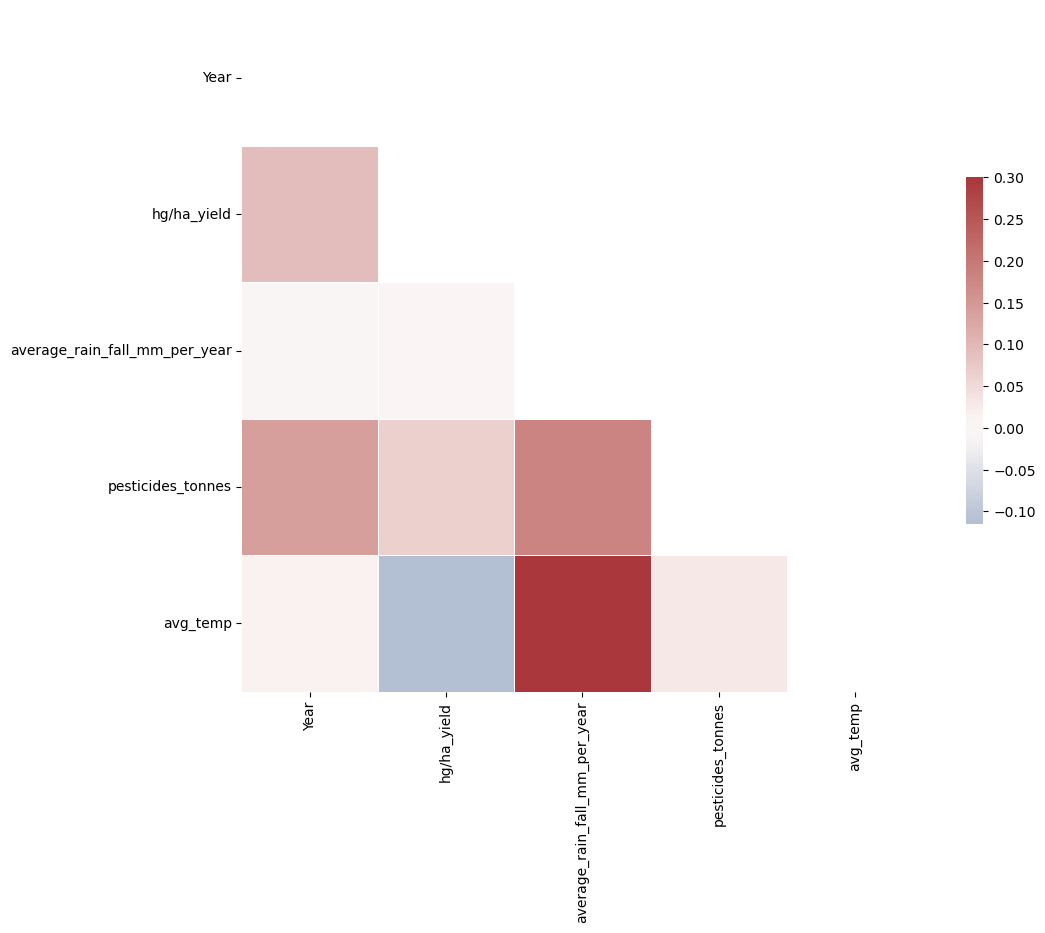

In [39]:
correlation_data=yield_df_updated.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [40]:
#Data Prepocessing

In [41]:
yield_df_updated.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [42]:
from sklearn.preprocessing import OneHotEncoder

yield_df_onehot = pd.get_dummies(yield_df_updated, columns=['Area',"Item"], prefix = ['Country',"Item"])
features=yield_df_onehot.loc[:, yield_df_onehot.columns != 'hg/ha_yield']
label=yield_df_updated['hg/ha_yield']
features.head()

,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,1990,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1990,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1990,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1990,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1990,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [43]:
features = features.drop(['Year'], axis=1)

In [44]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28241
Columns: 114 entries, average_rain_fall_mm_per_year to Item_Yams
dtypes: float64(3), uint8(111)
memory usage: 3.9 MB


In [45]:
features.head()

,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,1485.0,121.0,16.37,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1485.0,121.0,16.37,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1485.0,121.0,16.37,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1485.0,121.0,16.37,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1485.0,121.0,16.37,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [46]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
features=scaler.fit_transform(features)
features

array([[4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49670743e-01, 3.28894097e-04, 5.13458262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90028222e-01, 6.93361288e-03, 6.28960818e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [47]:
#write final df to csv file 
#yield_df_updated.to_csv('C:/Users/Sireesha Chimbili/Documents/Crop Data/yield_df_updated_me.csv')

In [48]:
#Training
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.25, random_state=42)

In [49]:
#Modeling
from sklearn.metrics import r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit=model.fit(train_data,train_labels)
    y_pred=fit.predict(test_data)
    r2=r2_score(test_labels,y_pred)
    return([model_name,r2])

In [51]:
# import necessary libraries

import boto3
import pandas as pd
import numpy as np
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

set up the SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
container = get_image_uri(sagemaker_session.boto_region_name, 'decision-trees')
dt = sagemaker.estimator.Estimator(container,
                                   role,
                                   train_instance_count=1,
                                   train_instance_type='ml.m4.xlarge',
                                   output_path='s3://dsde-sireesha-chimbili/output',
                                   sagemaker_session=sagemaker_session)

dt.set_hyperparameters(max_depth=5,
                       min_samples_split=5,
                       min_samples_leaf=5)

dt.fit({'train': train_data, 'validation': test_data})



In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
     RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
   DecisionTreeRegressor()
]

In [53]:
model_train=list(map(compare_models,models)) 

In [55]:
print(*model_train, sep = "\n")

['GradientBoostingRegressor', 0.8976184059117452]
['RandomForestRegressor', 0.6854396601072754]
['SVR', -0.19899003369459112]
['DecisionTreeRegressor', 0.956461268523735]


In [56]:
yield_df_onehot = yield_df_onehot.drop(['Year'], axis=1)

In [57]:
yield_df_onehot.head()

,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,36613,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,66667,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,23333,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,12500,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7000,1485.0,121.0,16.37,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [58]:
#setting test data to columns from dataframe and excluding 'hg/ha_yield' values where ML model should be predicting 

test_df=pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'hg/ha_yield'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=test_df[[col for col in test_df.columns if 'Country' in col]].stack()[test_df[[col for col in test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]
itm=test_df[[col for col in test_df.columns if 'Item' in col]].stack()[test_df[[col for col in test_df.columns if 'Item' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

In [59]:
test_df.head()

,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Country_Albania,Country_Algeria,Country_Angola,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,0.183443,0.110716,0.542078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.458451,0.000413,0.627257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.183443,0.106159,0.518228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.000000,0.224154,0.890971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.458451,0.000355,0.625213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
test_df.drop([col for col in test_df.columns if 'Item' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'Country' in col],axis=1,inplace=True)
test_df.head()

,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0.183443,0.110716,0.542078
1,0.458451,0.000413,0.627257
2,0.183443,0.106159,0.518228
3,1.000000,0.224154,0.890971
4,0.458451,0.000355,0.625213


In [61]:
test_df['Country']=countries
test_df['Item']=items
test_df.head()

,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Country,Item
0,0.183443,0.110716,0.542078,Spain,"Rice, paddy"
1,0.458451,0.000413,0.627257,Madagascar,Wheat
2,0.183443,0.106159,0.518228,Spain,Sorghum
3,1.000000,0.224154,0.890971,Colombia,Potatoes
4,0.458451,0.000355,0.625213,Madagascar,Sweet potatoes


In [79]:
dtree=DecisionTreeRegressor()
dtreemodel=dtree.fit(train_data,train_labels)

test_df["yield_predicted"]= dtree.predict(test_data)
test_df["yield_predicted"].head()

0     69220.0
1     23442.0
2     55615.0
3    156377.0
4     53407.0
Name: yield_predicted, dtype: float64

In [80]:
test_df["yield_actual"]=pd.DataFrame(test_labels)["hg/ha_yield"].tolist()
test_group=test_df.groupby("Item")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

Item
Cassava                 0.923988
Maize                   0.902147
Plantains and others    0.812003
Potatoes                0.904320
Rice, paddy             0.893095
Sorghum                 0.778364
Soybeans                0.879344
Sweet potatoes          0.826829
Wheat                   0.914520
Yams                    0.920482
dtype: float64

In [66]:
import pickle
pickle.dump(dtreemodel,open('dtree_model.pkl','wb'))

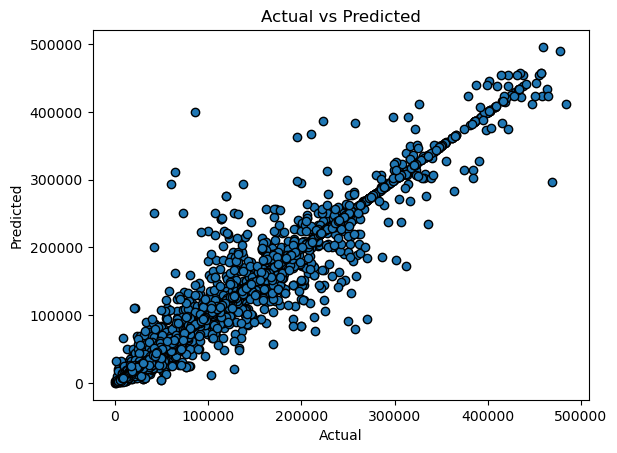

In [67]:
# So let's run the model actual values against the predicted ones 

fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [68]:
def adjusted_r_squared(y,yhat,x):
    score=1- (((1-(r2_score(y,yhat)))*(len(y)-1))/(len(y)-x.shape[1]-2))
    return score

test_group.apply(lambda x: adjusted_r_squared(x.yield_actual,x.yield_predicted,x))

Item
Cassava                 0.922518
Maize                   0.897839
Plantains and others    0.805050
Potatoes                0.903472
Rice, paddy             0.892888
Sorghum                 0.791763
Soybeans                0.873831
Sweet potatoes          0.824123
Wheat                   0.926081
Yams                    0.922461
dtype: float64

In [71]:
varimp= {'imp':dtreemodel.feature_importances_,'names':yield_df_onehot.columns[yield_df_onehot.columns!="hg/ha_yield"]}

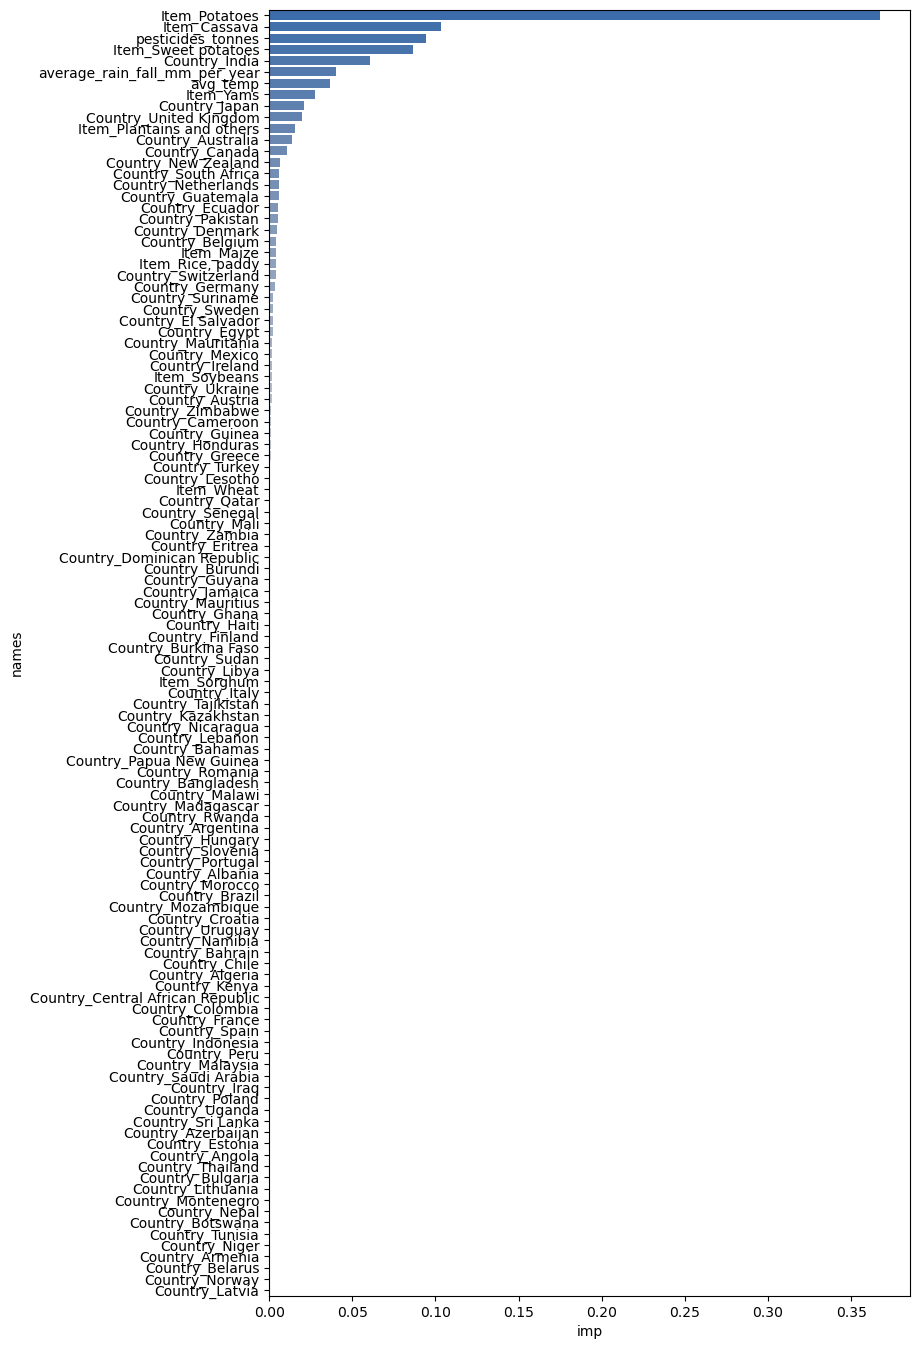

In [72]:
a4_dims = (8.27,16.7)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["imp"],inplace=True)
df=df.dropna()
sns.barplot(x="imp",y="names",palette="vlag",data=df,orient="h",ax=ax);

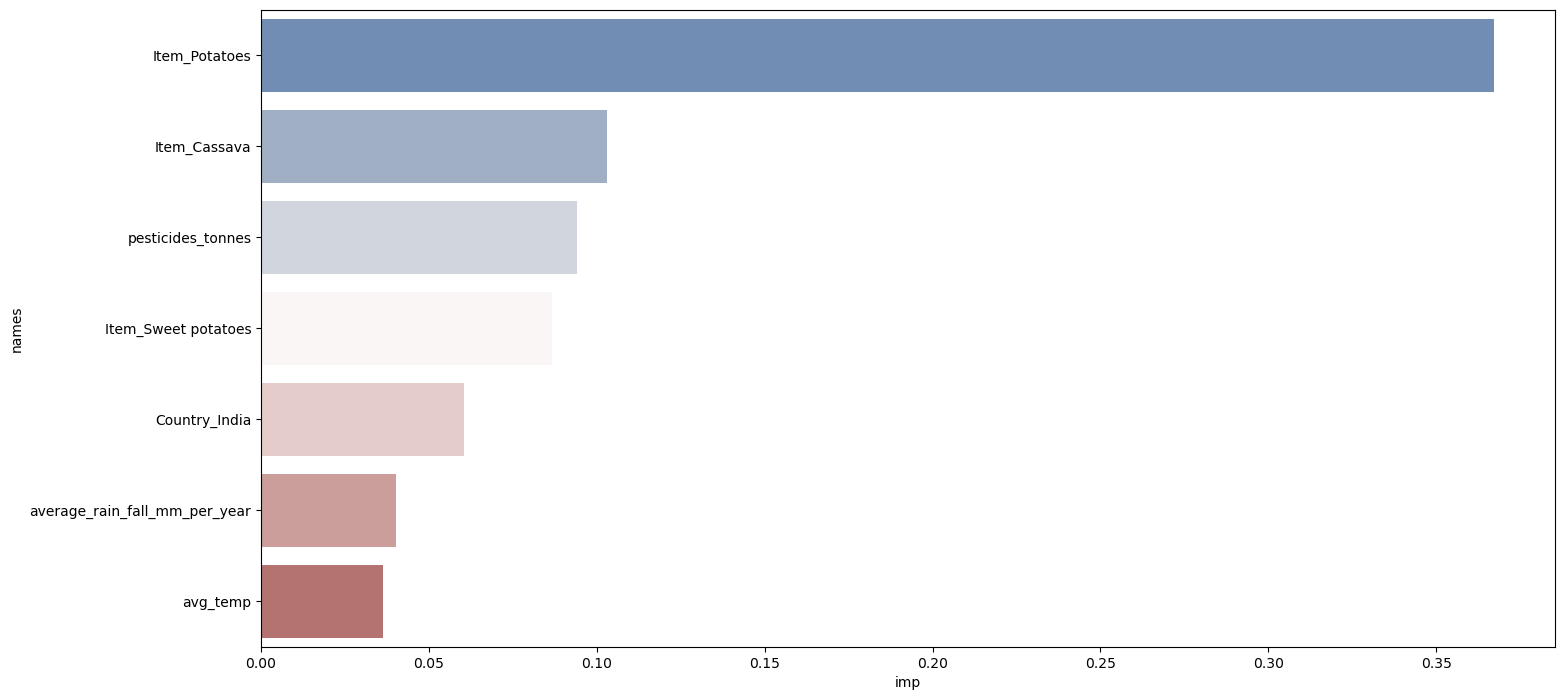

In [73]:
#7 most important factors that affect crops 
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["imp"],inplace=True)
df=df.dropna()
df=df.nlargest(7, 'imp')
sns.barplot(x="imp",y="names",palette="vlag",data=df,orient="h",ax=ax);

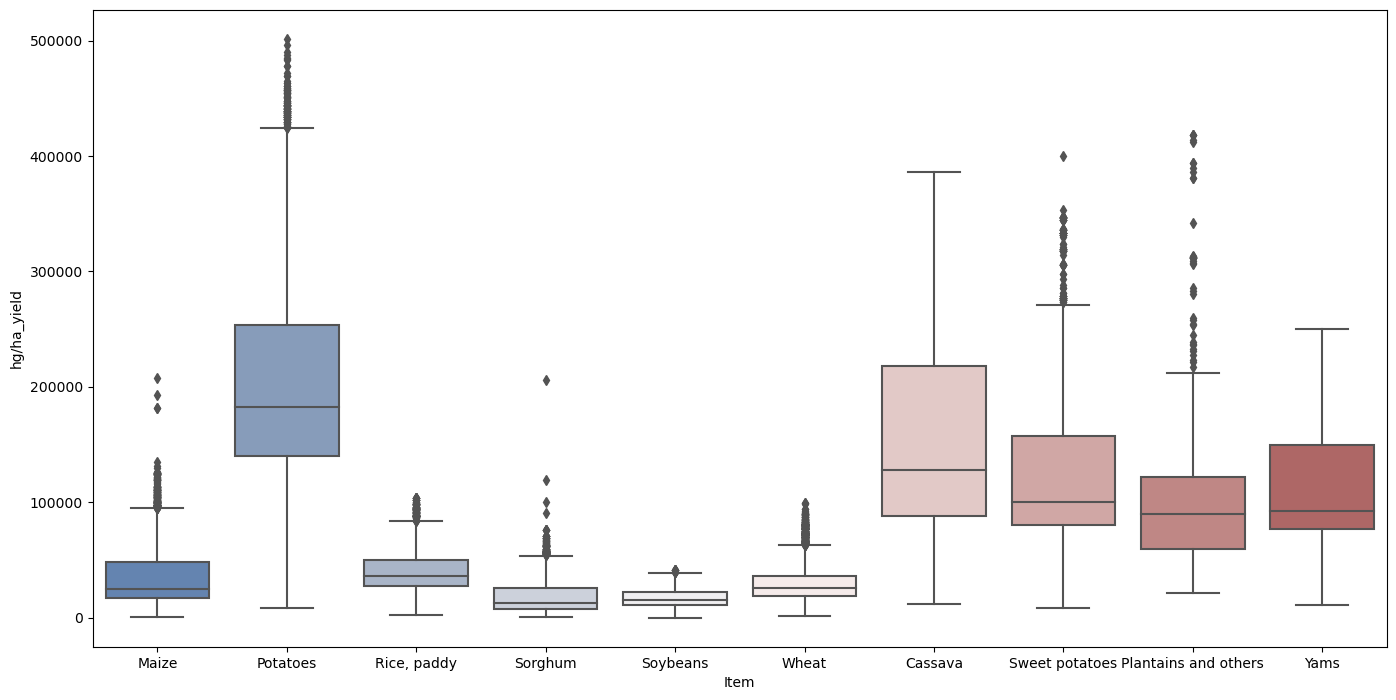

In [74]:
#Boxplot that shows yield for each item 
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="Item",y="hg/ha_yield",palette="vlag",data=yield_df_updated,ax=ax);